In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pairs = [['IEMG', 'EEM'], ['ARKK', 'ARKW'], ['TLT', 'SPTL'], ['SHY', 'VGSH'], ['SOXX', 'ITA']]

downloadable_tickers = [ticker for pair in pairs for ticker in pair]

training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2020-12-31')['Close']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_2186/859288907.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  10 of 10 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_2186/859288907.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2020-12-31')['Close']
[*********************100%***********************]  10 of 10 completed


In [15]:
def zscore_calc(series):
    return (series - series.mean()) / series.std()

In [16]:
training_spreads = {}
testing_spreads = {}

for etf1, etf2 in pairs:
    train_z1, train_z2 = zscore_calc(training_data[etf1]), zscore_calc(training_data[etf2])

    test_z1, test_z2 = zscore_calc(testing_data[etf1]), zscore_calc(testing_data[etf2])

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[f'{etf1}_{etf2}'], testing_spreads[f'{etf1}_{etf2}'] = training_spread, testing_spread

training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

In [17]:
def create_sequences(data, window_size):
    X, y  = [], []

    for i in range(len(data) - window_size):
        X.append(data.iloc[i : i + window_size])
        y.append(data.iloc[i + window_size])

        X_1 = np.array(X)
        y_1 = np.array(y)

    return torch.tensor(X_1, dtype = torch.float32), torch.tensor(y_1, dtype = torch.float32)

In [18]:
X_train, y_train = create_sequences(training_spreads_df['IEMG_EEM'], window_size = 30)
X_test, y_test = create_sequences(testing_spreads_df['IEMG_EEM'], window_size = 30)

In [19]:
class SpreadLSTM(nn.Module):
    def __init__(self, input_size = 1,  hidden_size = 1, num_layers = 1):
        super(SpreadLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out

In [20]:
train_dataset = TensorDataset(X_train.unsqueeze(-1), y_train.unsqueeze(-1))
test_dataset = TensorDataset(X_test.unsqueeze(-1), y_test.unsqueeze(-1))

train_loader = DataLoader(train_dataset, batch_size = 64)
test_loader = DataLoader(test_dataset, batch_size = 64)

In [21]:
device = torch.device('cpu')
model = SpreadLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

epochs = 50
model.train()

for epoch in range(epochs):
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")
    

Epoch 1/50 - Loss: 0.1587
Epoch 2/50 - Loss: 0.1402
Epoch 3/50 - Loss: 0.1226
Epoch 4/50 - Loss: 0.1060
Epoch 5/50 - Loss: 0.0906
Epoch 6/50 - Loss: 0.0763
Epoch 7/50 - Loss: 0.0632
Epoch 8/50 - Loss: 0.0514
Epoch 9/50 - Loss: 0.0410
Epoch 10/50 - Loss: 0.0320
Epoch 11/50 - Loss: 0.0243
Epoch 12/50 - Loss: 0.0180
Epoch 13/50 - Loss: 0.0130
Epoch 14/50 - Loss: 0.0091
Epoch 15/50 - Loss: 0.0063
Epoch 16/50 - Loss: 0.0042
Epoch 17/50 - Loss: 0.0028
Epoch 18/50 - Loss: 0.0019
Epoch 19/50 - Loss: 0.0013
Epoch 20/50 - Loss: 0.0010
Epoch 21/50 - Loss: 0.0008
Epoch 22/50 - Loss: 0.0007
Epoch 23/50 - Loss: 0.0006
Epoch 24/50 - Loss: 0.0006
Epoch 25/50 - Loss: 0.0006
Epoch 26/50 - Loss: 0.0006
Epoch 27/50 - Loss: 0.0006
Epoch 28/50 - Loss: 0.0006
Epoch 29/50 - Loss: 0.0006
Epoch 30/50 - Loss: 0.0006
Epoch 31/50 - Loss: 0.0006
Epoch 32/50 - Loss: 0.0006
Epoch 33/50 - Loss: 0.0006
Epoch 34/50 - Loss: 0.0006
Epoch 35/50 - Loss: 0.0006
Epoch 36/50 - Loss: 0.0006
Epoch 37/50 - Loss: 0.0006
Epoch 38/5

In [22]:
model.eval()
test_loss = 0
preds = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        preds.append(pred.cpu())
        loss = criterion(pred, yb)
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")

Test Loss: 0.0002


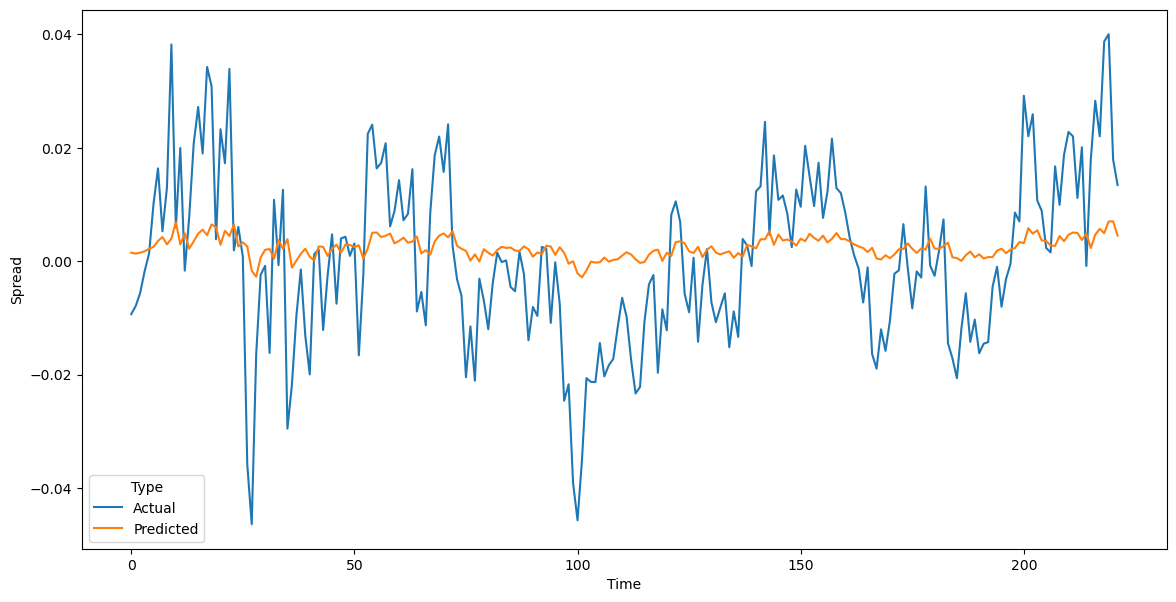

In [23]:
y_pred = torch.cat(preds).numpy()

y_pred_np = y_pred.flatten()
y_test_np = y_test.cpu().numpy().flatten()

plot_df = pd.DataFrame({
    'Time': range(len(y_test_np)),
    'Actual': y_test_np,
    'Predicted': y_pred_np
})

plot_df = plot_df.melt(id_vars = 'Time', value_vars = ['Actual', 'Predicted'], var_name = 'Type', value_name = 'Spread')

plt.subplots(figsize = (14, 7))

sns.lineplot(data = plot_df, x = 'Time', y = 'Spread', hue = 'Type')
plt.show()

In [24]:
def predict_mean_reversion(actual_spread, predicted_spread, threshold = 1):
    signals = []
    for current, pred in zip(actual_spread, predicted_spread):
        if current > threshold and current > pred:
            signals.append("short")
        elif current < -threshold and pred > current:
            signals.append("long")
        else:
            signals.append("hold")

    return pd.DataFrame({'actual': actual_spread,
                         'predicted': predicted_spread,
                         'signals': signals})

In [25]:
signals_df = predict_mean_reversion(y_test_np, y_pred_np, threshold = 0.4)

print(signals_df['signals'].value_counts())

signals
hold    222
Name: count, dtype: int64


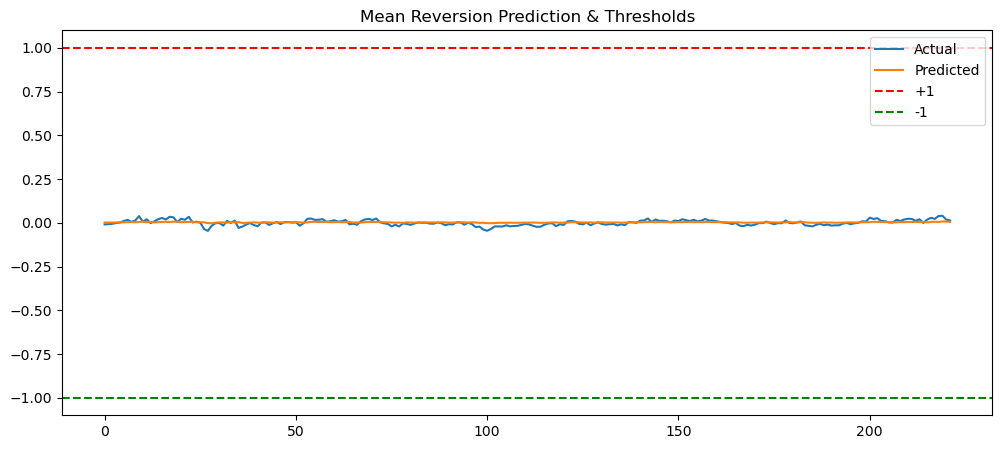

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(signals_df['actual'], label="Actual")
plt.plot(signals_df['predicted'], label="Predicted")
plt.axhline(1, color='red', linestyle='--', label='+1')
plt.axhline(-1, color='green', linestyle='--', label='-1')
plt.title("Mean Reversion Prediction & Thresholds")
plt.legend()
plt.show()